In [1]:
from PIL import Image
import rasterio
import numpy as np
import glob
import os

In [31]:
# fp = '/oak/stanford/groups/deho/building_compliance/san_jose_naip/2020/'
# fp_out = '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/'

fp = '/oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint/'
fp_out = '/oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint_512/'

## Preprocess: move TIF to parent directory

Only for LA

In [9]:
from os import listdir, rmdir
from shutil import move
for i in glob.glob(f'{fp}*'):
    for j in glob.glob(f'{i}/*'):
        for filename in listdir(j):
            move(os.path.join(j, filename), os.path.join(i, filename))
        rmdir(j)

/oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint/valley/m_3411852_se_11_h_20160616
m_3411852_se_11_h_20160616.txt
m_3411852_se_11_h_20160616.tif
/oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint/valley/m_3411853_nw_11_h_20160711
m_3411853_nw_11_h_20160711.txt
m_3411853_nw_11_h_20160711.tif
/oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint/valley/m_3411853_ne_11_h_20160711
m_3411853_ne_11_h_20160711.txt
m_3411853_ne_11_h_20160711.tif
/oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint/valley/m_3411845_sw_11_h_20160711
m_3411845_sw_11_h_20160711.txt
m_3411845_sw_11_h_20160711.tif
/oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint/valley/m_3411844_sw_11_h_20160616
m_3411844_sw_11_h_20160616.tif
m_3411844_sw_11_h_20160616.txt
/oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint/valley/m_3411853_se_11_h_201

In [51]:
# /oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint/wilshire/m_3411861_se_11_h_20160711.tif

with rio.open('/oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint/wilshire/m_3411861_se_11_h_20160711.tif') as inds:
    print(inds.meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 10290, 'height': 12190, 'count': 4, 'crs': CRS.from_epsg(26911), 'transform': Affine(0.6, 0.0, 367092.0,
       0.0, -0.6, 3770172.0)}


# Begin splitting tile

In [10]:
if not os.path.exists(fp_out):
    os.mkdir(fp_out)

if not os.path.exists(os.path.join(fp_out, 'raw_tif')):
    os.mkdir(os.path.join(fp_out, 'raw_tif'))

if not os.path.exists(os.path.join(fp_out, 'images')):
    os.mkdir(os.path.join(fp_out, 'images'))

if not os.path.exists(os.path.join(fp_out, 'mask')):
    os.mkdir(os.path.join(fp_out, 'mask'))

In [30]:
def save_tif_npy(numpyImage, fn_out):
    # save to both npy
    np.save(os.path.join(fp_out, 'images', f'{fn_out}.npy'),
            numpyImage)

In [32]:
# for i in glob.glob(f'{fp}*'):

for j in glob.glob(f'{fp}*'):
    for i in glob.glob(f'{j}/*'):
        if 'tif' in i:
            tif_name = i.split('/')[-1].split('.')
            im = Image.open(i)
            numpyImage = np.array(im)
            row_min = 0
            row_max = 512
            count = 0
            while row_min < numpyImage.shape[0]:
                col_min = 0
                col_max = 512
                while col_min < numpyImage.shape[1]:
                    fn_out = f'{tif_name[0]}_{count}'
                    if row_max > numpyImage.shape[0]:
                        if col_max > numpyImage.shape[1]:
                            save_tif_npy(numpyImage[row_min:, col_min:, :], fn_out)
                            count += 1
                        else:
                            save_tif_npy(numpyImage[row_min:, col_min:col_max, :], fn_out)
                            count += 1
                    else:
                        if col_max > numpyImage.shape[1]:
                            save_tif_npy(numpyImage[row_min:row_max, col_min:, :], fn_out)
                            count += 1
                        else:
                            save_tif_npy(numpyImage[row_min:row_max, col_min:col_max, :], fn_out)
                            count += 1
                    col_min = col_max
                    col_max += 512
                row_min = row_max
                row_max += 512

In [52]:
# SPLIT TIF
import os
from itertools import product
import rasterio as rio
from rasterio import windows


# in_path = '/oak/stanford/groups/deho/building_compliance/san_jose_naip/2020/'

# out_path = '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/raw_tif/'

in_path = '/oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint/'
out_path = '/oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint_512/raw_tif/'

def get_tiles(ds, width=512, height=512):
    nols, nrows = ds.meta['width'], ds.meta['height']
#     print(nols, nrows)
    offsets = product(range(0, nrows, height), range(0, nols, width))
    offsets = [(i[1], i[0]) for i in offsets]
#     print(offsets)
    big_window = windows.Window(col_off=0, row_off=0, width=nols, height=nrows)
    for col_off, row_off in  offsets:
        window =windows.Window(col_off=col_off, row_off=row_off, width=width, height=height).intersection(big_window)
        transform = windows.transform(window, ds.transform)
        yield window, transform

# for i in glob.glob(f'{fp}*'):

for j in glob.glob(f'{in_path}*'):
    for i in glob.glob(f'{j}/*'):
        if 'tif' in i:
            input_filename = i.split('/')[-1].split('.')
            fn_out = '{}_{}.tif'

            with rio.open(i) as inds:
                tile_width, tile_height = 512, 512

                meta = inds.meta.copy()

                count = 0
                for window, transform in get_tiles(inds):
                    meta['transform'] = transform
                    meta['width'], meta['height'] = window.width, window.height
                    outpath = os.path.join(out_path,fn_out.format(input_filename[0], count))
                    with rio.open(outpath, 'w', **meta) as outds:
                        outds.write(inds.read(window=window))
                    count += 1

## Generate masks from OSMBuildings

In [48]:
# fp = '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/raw_tif/'
# fp_out = '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/mask/'

fp = '/oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint_512/raw_tif/'
fp_out = '/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/'
fp_out1 = '/oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint_512/train/images/'

In [14]:
from shapely.geometry import box
import pyproj
from shapely.ops import transform
import geopandas as gpd
from shapely.ops import unary_union
import shapely
from rasterio.mask import mask
import pickle

Open OSMBuildings shapefile

In [27]:
len(os.listdir(fp))

14112

In [27]:
with open('data/san_jose/no_buildings.p', 'rb') as f:
    no_buildings = pickle.load(f)

In [16]:
with open('data/los_angeles/no_buildings.txt', 'r') as f:
    no_buildings = f.readlines()
    no_buildings = [line.rstrip() for line in no_buildings]

In [17]:
len(no_buildings)

7842

In [12]:
no_buildings

['m_3311814_nw_11_h_20160710_199',
 'm_3411863_sw_11_h_20160706_242',
 'm_3311813_ne_11_h_20160711_12',
 'm_3411863_sw_11_h_20160706_358',
 'm_3411852_se_11_h_20160616_349',
 'm_3311807_nw_11_h_20160706_323',
 'm_3311806_se_11_h_20160707_311',
 'm_3311807_sw_11_h_20160706_334',
 'm_3411861_se_11_h_20160711_70',
 'm_3411853_ne_11_h_20160711_209',
 'm_3311814_nw_11_h_20160710_2',
 'm_3311806_se_11_h_20160707_405',
 'm_3411845_se_11_h_20160711_42',
 'm_3311813_ne_11_h_20160711_282',
 'm_3411845_se_11_h_20160711_219',
 'm_3311806_sw_11_h_20160710_246',
 'm_3311806_sw_11_h_20160710_136',
 'm_3411853_sw_11_h_20160711_320',
 'm_3411844_sw_11_h_20160616_269',
 'm_3411862_se_11_h_20160707_328',
 'm_3311813_ne_11_h_20160711_246',
 'm_3411852_sw_11_h_20160616_25',
 'm_3411845_sw_11_h_20160711_26',
 'm_3311813_se_11_h_20160711_24',
 'm_3411853_se_11_h_20160711_389',
 'm_3311806_sw_11_h_20160710_63',
 'm_3411861_se_11_h_20160711_294',
 'm_3411845_sw_11_h_20160711_232',
 'm_3411862_se_11_h_20160707_

In [54]:
len(os.listdir(os.path.join(fp_out, 'val', 'masks')))

427

In [55]:
len(os.listdir(os.path.join(fp_out, 'val', 'masks_wt')))

427

In [45]:
len(done)

6270

In [22]:
combined = no_buildings + no_buildings1

In [26]:
with open('data/san_jose/no_buildings.p', 'wb') as f:
    pickle.dump(combined, f)

In [8]:
no_buildings = []
done = []
count = 0
for i in glob.glob(f'{fp}*'):
    fn = i.split('/')[-1].split('.')[0]
#     if f'{fn}.npy' in done:
#         print(fn)
    if fn in no_buildings or f'{fn}.npy' in done:
        pass
    else:
        with rasterio.open(i) as inds:
            bounds = inds.bounds
            geom = box(*bounds)
            wgs84 = pyproj.CRS('EPSG:26911')
            utm = pyproj.CRS('EPSG:4326')

            project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
            utm_point = shapely.ops.transform(project, geom)

#             df = gpd.read_file('../../all_buildings/data/input/OSM/san_jose.geojson', mask=utm_point)
            df = gpd.read_file('data/los_angeles/la_select_footprints.geojson', mask=utm_point)
            if len(df) == 0:
                no_buildings.append(fn)
                print(i)
            else:
                df = df.to_crs('epsg:26911')
                mask_im, trans = rasterio.mask.mask(inds, list(df['geometry']))
                mask_im = np.rollaxis(mask_im, 0, 3)

                mask = np.zeros((mask_im.shape[0], mask_im.shape[1]))
                mask[np.sum(mask_im == 0, axis=2) < 4] = 1 # need to check that this is right
                print(mask.sum())
                print(mask.shape)
#                 np.save(os.path.join(fp_out, f'{fn}.npy'),
#                     mask)


83124.0
(512, 512)
/oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint_512/raw_tif/m_3411862_se_11_h_20160707_95.tif
/oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint_512/raw_tif/m_3411853_se_11_h_20160711_124.tif
54245.0
(512, 512)
65574.0
(512, 512)


KeyboardInterrupt: 

In [9]:
import multiprocessing as mp

all_files = glob.glob(f'{fp}*')
# fn = [i.split('/')[-1].split('.')[0] for i in all_files]
# filtered = [i for i in fn if i not in no_buildings and f'{i}.npy' not in done]
# print(len(fn))
# print(len(filtered))

In [10]:
def driver(i):
    fn = i.split('/')[-1].split('.')[0]
    if fn in no_buildings_global or f'{fn}.npy' in done_global:
        pass
    else:
        with rasterio.open(i) as inds:
            bounds = inds.bounds
            geom = box(*bounds)
            wgs84 = pyproj.CRS('EPSG:26911')
            utm = pyproj.CRS('EPSG:4326')

            project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
            utm_point = shapely.ops.transform(project, geom)

    #             df = gpd.read_file('../../all_buildings/data/input/OSM/san_jose.geojson', mask=utm_point)
            df = gpd.read_file('data/los_angeles/la_select_footprints.geojson', mask=utm_point)
            if len(df) == 0:
    #                 no_buildings.append(fn)

                with open('data/los_angeles/no_buildings.txt', 'a') as f:
                    f.write(f'{fn}\n')

            else:
                df = df.to_crs('epsg:26911')
                mask_im, trans = rasterio.mask.mask(inds, list(df['geometry']))
                mask_im = np.rollaxis(mask_im, 0, 3)

                mask = np.zeros((mask_im.shape[0], mask_im.shape[1]))
                mask[np.sum(mask_im == 0, axis=2) < 4] = 1 # need to check that this is right
    #             np.save(os.path.join('/oak/stanford/groups/deho/building_compliance/san_jose_naip_512/mask/',
    #                                  f'{fn}.npy'),
    #                 mask)

                np.save(os.path.join('/oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint_512/mask/',
                                     f'{fn}.npy'),
                    mask)

                
def make_global(no_buildings, done):
    global no_buildings_global
    global done_global
    
    no_buildings_global = no_buildings
    done_global = done


In [11]:
nprocs = mp.cpu_count()

In [ ]:
p = mp.Pool(processes=nprocs, initializer=make_global, initargs=(no_buildings, done,))
p.map(driver, all_files)

# p = mp.Pool(processes=nprocs)
# p.map(driver, all_files)

# Delete raw_tif/ and images/ that have no buildings in them

In [35]:
with open('data/los_angeles/no_buildings.txt', 'r') as f:
    no_buildings = f.readlines()
    no_buildings = [line.rstrip() for line in no_buildings]

In [36]:
fp = '/oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint_512/'

In [37]:
glob.glob(f'{fp}*')

['/oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint_512/raw_tif',
 '/oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint_512/train']

In [43]:
for i in no_buildings:
    if os.path.exists(os.path.join(fp, 'train', 'images', f'{i}.npy')):
        os.remove(os.path.join(fp, 'train', 'images', f'{i}.npy'))
#     if os.path.exists(os.path.join(fp, 'raw_tif', f'{i}.tif')):
#         os.remove(os.path.join(fp, 'raw_tif', f'{i}.tif'))

# Find out which images are not 512x512

In [34]:
fp = '/oak/stanford/groups/deho/building_compliance/los_angeles_naip/2016_rgb_footprint_512/'

In [35]:
for j in ['train', 'test', 'val']:
    total_count = len(os.listdir(f'{fp}{j}/images/'))
    count = 0
    for i in glob.glob(f'{fp}{j}/images/*'):
        npy = np.load(i)
        if npy.shape[0] != 512 or npy.shape[1] != 512:
            count += 1
    
    print(j)
    print(count, total_count, count/total_count)

train
429 5078 0.08448207955888144
test
54 627 0.0861244019138756
val
39 565 0.06902654867256637


In [45]:
for j in ['train', 'test', 'val']:
    total_count = len(os.listdir(f'{fp}{j}/images/'))
    print(total_count)

4851
599
540


In [36]:
os.mkdir(os.path.join(fp, 'not_512'))
os.mkdir(os.path.join(fp, 'not_512', 'train'))
os.mkdir(os.path.join(fp, 'not_512', 'test'))
os.mkdir(os.path.join(fp, 'not_512', 'val'))

In [37]:
for i in ['train', 'test', 'val']:
    os.mkdir(os.path.join(fp, 'not_512', i, 'images'))
    os.mkdir(os.path.join(fp, 'not_512', i, 'masks'))
    os.mkdir(os.path.join(fp, 'not_512', i, 'masks_wt'))

In [38]:
import shutil

In [39]:
for j in ['train', 'test', 'val']:
    total_count = len(os.listdir(f'{fp}{j}/images/'))
    for i in os.listdir(f'{fp}{j}/images/'):
        npy = np.load(f'{fp}{j}/images/{i}')
        if npy.shape[0] != 512 or npy.shape[1] != 512:
#             print(os.path.join(fp, j, 'images', i))
#             print(os.path.join(fp, 'not_512', j, 'images'))
#             print(os.path.join(fp, j, 'masks', i.replace(".npy", "_mask.npy")))
            shutil.move(os.path.join(fp, j, 'images', i), 
                        os.path.join(fp, 'not_512', j, 'images'))
            shutil.move(os.path.join(fp, j, 'masks', i.replace(".npy", "_mask.npy")), 
                        os.path.join(fp, 'not_512', j, 'masks'))
            shutil.move(os.path.join(fp, j, 'masks_wt', i.replace(".npy", "_mask_wt.npy")), 
                        os.path.join(fp, 'not_512', j, 'masks_wt'))

# Reshape non-512x512

In [43]:
import cv2
import matplotlib.pyplot as plt

dim = (512, 512)

for j in ['train', 'test', 'val']:
    for i in os.listdir(os.path.join(fp, 'not_512', j, 'images')):
        img = np.load(os.path.join(fp, 'not_512', j, 'images', i))
        mask = np.load(os.path.join(fp, 'not_512', j, 'masks', i.replace('.npy', '_mask.npy')))
        if img.shape[0] >= 250 and img.shape[1] >= 250:
            resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
            resized_mask = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)
#             print(os.path.join(fp, 'train', 'images', i))
#             print(os.path.join(fp, 'train', 'masks', i.replace('.npy', '_mask.npy')))

            np.save(os.path.join(fp, j, 'images', i),
                resized)

            np.save(os.path.join(fp, j, 'masks', i.replace('.npy', '_mask.npy')),
                resized_mask)

#             plt.imshow(resized[:, :, :3])
#             plt.show()

#             plt.imshow(resized_mask)
#             plt.show()

In [19]:
print('Original Dimensions : ',img.shape)

Original Dimensions :  (512, 282)


In [20]:
dim = (512, 512)
 
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

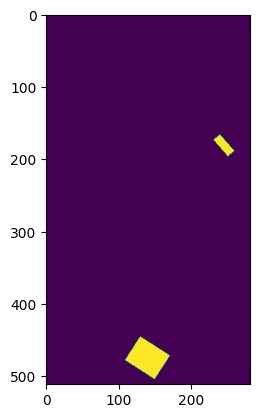

In [22]:
plt.imshow(img)
plt.show()

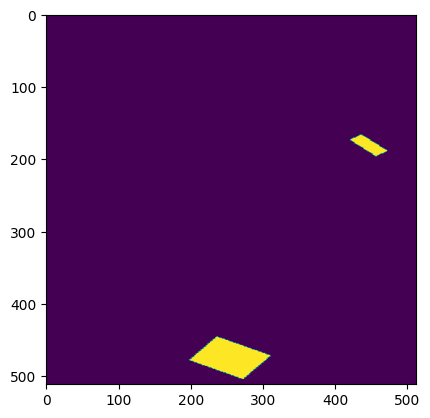

In [23]:
plt.imshow(resized)
plt.show()

In [ ]:
print('Original Dimensions : ',img.shape)

dim = (512, 512)
 
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
 
print('Resized Dimensions : ',resized.shape)
 
cv2.imshow("Resized image", resized)